In [1]:
from IPython.display import clear_output

import os
import torch, torchvision
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm

import cnn
import competitors
import geex

random_seed = 1
torch.manual_seed(random_seed)

/srv/public/.local/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


### Preparation
- Loading a simple CNN and the test set from MNIST
- Initializing a GEEX instance
- Initializing an IG instance as a reference

In [2]:
# Loading MNIST test set for testing the explanation method
IMG_SIZE = (1, 28, 28)
PIX_MEAN, PIX_STD = (0.1307, ), (0.3081, )

transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(),
     torchvision.transforms.Normalize(PIX_MEAN, PIX_STD)]
)

testset = torchvision.datasets.MNIST(root='./files', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)
test_iter = enumerate(test_loader)

m_pth = './checkpoints/mnist_cnn_model.pt'
if not os.path.isfile(m_pth):
    # Train a simple CNN as the black box if none is found under the given path
    trainset = torchvision.datasets.MNIST(root='./files', train=True, download=True, transform=transform)
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
    cnn.train(train_loader, IMG_SIZE, m_pth)

m = cnn.CNNSoftmax(IMG_SIZE).cuda()
m.eval()
m.load_state_dict(torch.load(m_pth))

cnn.get_acc(m, test_loader)

/srv/public/.local/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Accuracy: [96.87]


In [3]:
# Initializing GEEX
num_masks, sigma = 5000, 1.0
baseline = 0    
expl_ge = geex.GEEX(num_masks, sigma, IMG_SIZE)

# Initializing IG
expl_ig = competitors.IntegratedGrad(50, IMG_SIZE, baseline)

### Visualization of the explanation results via saliency maps

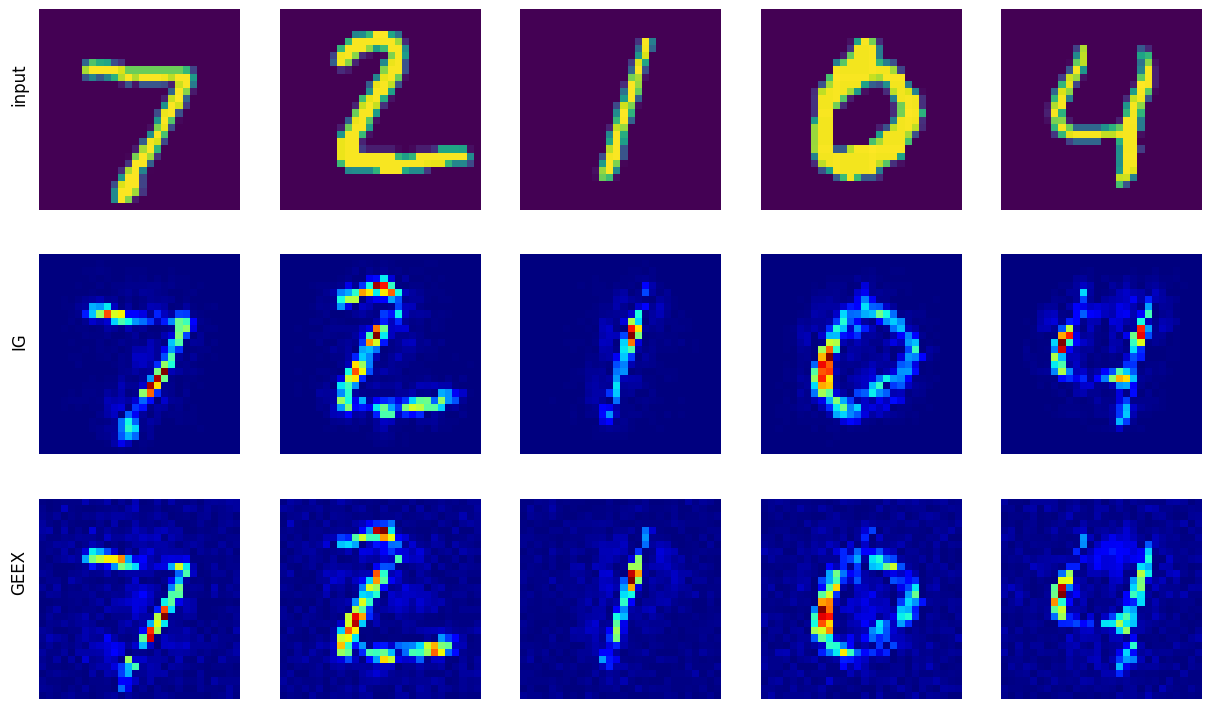

In [4]:
cmap = 'jet'
_, (batch_imgs, batch_labels) = next(test_iter)
expls = [expl_ig, expl_ge]

examples2show = 5
rels2show = len(expls)+1
fig, axs = plt.subplots(rels2show, examples2show, figsize=(3*examples2show, 3*rels2show))
for row in axs: 
    for ax in row: ax.axis('off')

for i, title in enumerate(['input', 'IG', 'GEEX']):
    axs[i][0].set_title(title, rotation='vertical', x=-0.1, y=0.5)

for col_id in range(examples2show):
    img = batch_imgs[col_id].unsqueeze(dim=0)
    axs[0][col_id].imshow(img[0][0])

    for row_id, expl in enumerate(expls):
        rel = abs(expl.explain(m, img)[0])
        axs[row_id+1][col_id].imshow(rel, cmap=cmap)

### Evaluate explainers with normalized AOPCs

In [5]:
import evaluation

In [6]:
for expl in expls:
    records = evaluation.evaluate_via_deletion(
        expl, m, test_loader, IMG_SIZE, v_default=0, num_instances=100
        )
    aopc = evaluation.compute_aopc(torch.tensor(records).mean(dim=0))
    print(f'AOPC of [{expl.__class__}]: {aopc}')

Num of instances for evaluation: 100


#Instances:   0%|          | 0/100 [00:00<?, ?it/s]

#Instances: 100%|██████████| 100/100 [00:17<00:00,  5.76it/s, Current edition: [790/784]]


AOPC of [<class 'competitors.IntegratedGrad'>]: 0.946283221244812
Num of instances for evaluation: 100


#Instances: 100%|██████████| 100/100 [00:07<00:00, 13.70it/s, Current edition: [790/784]]

AOPC of [<class 'geex.GEEX'>]: 0.9482921957969666
